# Estima a População e PIB Municipal

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# População

In [28]:
pop_municipal = pd.read_csv(
    'data/csv/pop_municipal.csv', 
    delimiter=';', 
    skiprows=3,   # Pular as primeiras 3 linhas
    nrows=5570    # Ler apenas 5570 linhas, de 4 até 5574
)

In [29]:
proj_pop = pd.read_excel('data/excel/xlsx/projecoes_populacao_ibge.xlsx', engine = 'openpyxl')

In [30]:
pop_municipal.columns

Index(['Cód.', 'Município', '2001', '2002', '2003', '2004', '2005', '2006',
       '2008', '2009', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021'],
      dtype='object')

In [31]:
def adicionar_sigla(df):
    df['Sigla'] = df['Município'].str[-3:-1]
    df['Município'] = df['Município'].str[:-5]
    return df

pop_municipal_sigla = adicionar_sigla(pop_municipal)

In [32]:
def transformar_populacao(df):
    # Identificar as colunas de ano
    colunas_ano = [str(ano) for ano in range(2001, 2022) if str(ano) in df.columns]
    
    # Realizar o melt
    df_transformado = df.melt(
        id_vars=['Cód.', 'Município', 'Sigla'],  # Mantém essas colunas fixas
        value_vars=colunas_ano,  # Colunas a serem transformadas
        var_name='Ano',  # Nome da nova coluna para os anos
        value_name='População'  # Nome da nova coluna para os valores
    )
    
    # Retornar o DataFrame transformado
    return df_transformado

pop_municipal_transformado = transformar_populacao(pop_municipal)

In [33]:
def preencher_anos_ausentes(df):
    # Garantir que 'Ano' e 'População' sejam do tipo correto
    df['Ano'] = pd.to_numeric(df['Ano'], errors='coerce')
    df['População'] = pd.to_numeric(df['População'], errors='coerce')

    # Criar DataFrame para 2007
    dados_2007 = df[df['Ano'].isin([2006, 2008])].groupby('Cód.').agg(
        {'População': 'mean', 'Município': 'first', 'Sigla': 'first'}
    ).reset_index()
    dados_2007['Ano'] = 2007

    # Criar DataFrame para 2010
    dados_2010 = df[df['Ano'].isin([2009, 2011])].groupby('Cód.').agg(
        {'População': 'mean', 'Município': 'first', 'Sigla': 'first'}
    ).reset_index()
    dados_2010['Ano'] = 2010

    # Concatenar os novos dados com o DataFrame original
    df_preenchido = pd.concat([df, dados_2007, dados_2010], ignore_index=True)

    # Ordenar pelo ano para melhor visualização
    df_preenchido.sort_values(by=['Cód.', 'Ano'], inplace=True)

    return df_preenchido

pop_municipal_completo = preencher_anos_ausentes(pop_municipal_transformado)

In [34]:
def atualizar_pop_municipal(pop_municipal_completo, proj_pop):
    # Renomeando colunas
    pop_municipal_completo = pop_municipal_completo.rename(columns={
        'Cód.': 'cod_mun',
        'Município': 'municipio',
        'Sigla': 'sigla_uf',
        'Ano': 'ano',
        'População': 'pop_mun'
    })
    
    # Criando o intervalo de anos de 2001 a 2054
    anos_completos = pd.DataFrame({'ano': range(2001, 2055)})
    municipios = pop_municipal_completo[['cod_mun', 'municipio', 'sigla_uf']].drop_duplicates()
    todos_anos = municipios.merge(anos_completos, how='cross')
    
    # Unindo os dados com os anos completos
    pop_municipal_completo = todos_anos.merge(
        pop_municipal_completo,
        how='left',
        on=['cod_mun', 'municipio', 'sigla_uf', 'ano']
    )
    
    # Adicionando a coluna pop_uf com base na correspondência de sigla e ano
    pop_municipal_completo = pop_municipal_completo.merge(
        proj_pop.rename(columns={'sigla': 'sigla_uf', 'ano': 'ano', 'pop': 'pop_uf'}),
        how='left',
        on=['sigla_uf', 'ano']
    )
    
    # Garantindo que pop_mun fique vazio de 2022 a 2054 inicialmente
    pop_municipal_completo.loc[pop_municipal_completo['ano'].between(2022, 2054), 'pop_mun'] = None
    
    # Preenchendo pop_mun para os anos de 2022 a 2054
    for ano_atual in range(2022, 2055):  # Inclui 2054
        ano_anterior = ano_atual - 1
        condicao_atual = pop_municipal_completo['ano'] == ano_atual
        condicao_anterior = pop_municipal_completo['ano'] == ano_anterior
        
        # Obter os valores do período anterior
        df_anterior = pop_municipal_completo.loc[condicao_anterior, ['cod_mun', 'pop_uf', 'pop_mun']]
        df_anterior = df_anterior.rename(columns={'pop_uf': 'pop_uf_anterior', 'pop_mun': 'pop_mun_anterior'})
        
        # Mesclar os valores do período anterior
        pop_municipal_completo = pop_municipal_completo.merge(
            df_anterior,
            how='left',
            on='cod_mun'
        )
        
        # Calcular o valor de pop_mun atual
        pop_municipal_completo.loc[condicao_atual, 'pop_mun'] = (
            (pop_municipal_completo['pop_uf'] / pop_municipal_completo['pop_uf_anterior'] * 
            pop_municipal_completo['pop_mun_anterior']).round()
        )
        
        # Remover colunas temporárias
        pop_municipal_completo.drop(columns=['pop_uf_anterior', 'pop_mun_anterior'], inplace=True)
    
    return pop_municipal_completo

pop_municipal_final = atualizar_pop_municipal(pop_municipal_completo, proj_pop)

# PIB

In [35]:
correcao_valores = pd.read_excel('data/excel/xlsx/correcao_valores.xlsx', engine = 'openpyxl')

In [36]:
correcao_valores.columns

Index(['ano', 'corretor_ano_anterior', 'corretor_total'], dtype='object')

In [37]:
pib_municipal = pd.read_csv(
    'data/csv/pib_municipal.csv', 
    delimiter=';', 
    skiprows=3,   # Pular as primeiras 3 linhas
    nrows=5570    # Ler apenas 5570 linhas, de 4 até 5574
)

In [38]:
pib_municipal_sigla = adicionar_sigla(pib_municipal)

In [39]:
def transformar_pib_corrigido(df_pib, correcao_valores):
    # Identificar as colunas de ano
    colunas_ano = [str(ano) for ano in range(2001, 2022) if str(ano) in df_pib.columns]
    
    # Realizar o melt
    df_transformado = df_pib.melt(
        id_vars=['Cód.', 'Município', 'Sigla'],  # Mantém essas colunas fixas
        value_vars=colunas_ano,  # Colunas a serem transformadas
        var_name='Ano',  # Nome da nova coluna para os anos
        value_name='pib_mun'  # Nome da nova coluna para os valores
    )
    
    # Renomear as colunas
    df_transformado = df_transformado.rename(columns={
        'Cód.': 'cod_mun',
        'Município': 'municipio',
        'Sigla': 'sigla_uf',
        'Ano': 'ano',
    })
    
    # Garantir que `ano` seja numérico
    df_transformado['ano'] = pd.to_numeric(df_transformado['ano'], errors='coerce')
    correcao_valores['ano'] = pd.to_numeric(correcao_valores['ano'], errors='coerce')

    # Garantir que `pib_mun` seja numérico
    df_transformado['pib_mun'] = pd.to_numeric(df_transformado['pib_mun'], errors='coerce').fillna(0)
    
    # Mesclar com os valores de correção pelo ano
    df_transformado = df_transformado.merge(
        correcao_valores[['ano', 'corretor_total']], 
        on='ano', 
        how='left'
    )
    
    # Criar a coluna `pib_mun_corrigido`
    df_transformado['pib_mun_corrigido'] = (df_transformado['pib_mun'] * df_transformado['corretor_total']).round()
    
    # Retornar o DataFrame transformado e corrigido
    return df_transformado

# Exemplo de uso
pib_municipal_transformado = transformar_pib_corrigido(pib_municipal, correcao_valores)

In [40]:
def criar_pib_uf(df):
    # Garantir que pib_mun é numérico
    df['pib_mun'] = pd.to_numeric(df['pib_mun_corrigido'], errors='coerce').fillna(0)
    
    # Agrupar por sigla_uf e ano e calcular a soma de pib_mun
    pib_uf = df.groupby(['sigla_uf', 'ano'], as_index=False)['pib_mun'].sum()
    
    # Renomear a coluna pib_mun para pib_uf
    pib_uf = pib_uf.rename(columns={'pib_mun': 'pib_uf'})
    
    return pib_uf

# Exemplo de uso
pib_uf = criar_pib_uf(pib_municipal_transformado)

In [41]:
def criar_pib_uf_projecao(pib_uf):
    # Garantir que pib_uf é numérico
    pib_uf['pib_uf'] = pd.to_numeric(pib_uf['pib_uf'], errors='coerce').fillna(0)

    # Garantir que ano é numérico
    pib_uf['ano'] = pd.to_numeric(pib_uf['ano'], errors='coerce')

    # DataFrame para armazenar resultados
    resultados = []

    # Loop por cada sigla_uf única
    for sigla in pib_uf['sigla_uf'].unique():
        # Filtrar dados para a sigla_uf atual
        dados_sigla = pib_uf[pib_uf['sigla_uf'] == sigla]
        X = dados_sigla['ano'].values.reshape(-1, 1)
        y = dados_sigla['pib_uf'].values

        # Modelo linear
        modelo_linear = LinearRegression()
        modelo_linear.fit(X, y)
        r2_linear = modelo_linear.score(X, y)
        pib_2022_linear = modelo_linear.predict([[2022]])[0]
        pib_2054_linear = modelo_linear.predict([[2054]])[0]
        cagr_linear = (((pib_2054_linear / pib_2022_linear) ** (1 / 32)) - 1) * 100

        # Modelo potencial: log(y) = a * log(x) + b
        log_X = np.log(X + 1e-10).reshape(-1, 1)  # Adicionar pequena constante para evitar log(0)
        log_y = np.log(y + 1e-10)  # Evitar log(0)
        modelo_potencial = LinearRegression()
        modelo_potencial.fit(log_X, log_y)
        r2_potencial = modelo_potencial.score(log_X, log_y)
        pib_2022_potencial = np.exp(modelo_potencial.predict([[np.log(2022)]]))[0]
        pib_2054_potencial = np.exp(modelo_potencial.predict([[np.log(2054)]]))[0]
        cagr_potencial = (((pib_2054_potencial / pib_2022_potencial) ** (1 / 32)) - 1) * 100

        # Modelo exponencial: log(y) = a * x + b
        log_y = np.log(y + 1e-10)
        modelo_exponencial = LinearRegression()
        modelo_exponencial.fit(X, log_y)
        r2_exponencial = modelo_exponencial.score(X, log_y)
        pib_2022_exponencial = np.exp(modelo_exponencial.predict([[2022]])[0])
        pib_2054_exponencial = np.exp(modelo_exponencial.predict([[2054]])[0])
        cagr_exponencial = (((pib_2054_exponencial / pib_2022_exponencial) ** (1 / 32)) - 1) * 100

        # Modelo logarítmico: y = a * log(x) + b
        modelo_logaritmico = LinearRegression()
        modelo_logaritmico.fit(log_X, y)
        r2_logaritmico = modelo_logaritmico.score(log_X, y)
        pib_2022_logaritmico = modelo_logaritmico.predict([[np.log(2022)]])[0]
        pib_2054_logaritmico = modelo_logaritmico.predict([[np.log(2054)]])[0]
        cagr_logaritmico = (((pib_2054_logaritmico / pib_2022_logaritmico) ** (1 / 32)) - 1) * 100

        # Adicionar os resultados para esta sigla_uf
        resultados.append({
            'sigla_uf': sigla,
            'linear_coef': r2_linear,
            'linear_cagr': cagr_linear,
            'potencial_coef': r2_potencial,
            'potencial_cagr': cagr_potencial,
            'exponencial_coef': r2_exponencial,
            'exponencial_cagr': cagr_exponencial,
            'logaritmico_coef': r2_logaritmico,
            'logaritmico_cagr': cagr_logaritmico,
        })

    # Criar DataFrame com os resultados
    pib_uf_projecao = pd.DataFrame(resultados)
    return pib_uf_projecao

# Exemplo de uso
pib_uf_projecao = criar_pib_uf_projecao(pib_uf)

In [42]:
def criar_tabela_completa_multimodelo(pib_uf):
    # Garantir que pib_uf e ano sejam numéricos
    pib_uf['pib_uf'] = pd.to_numeric(pib_uf['pib_uf'], errors='coerce').fillna(0)
    pib_uf['ano'] = pd.to_numeric(pib_uf['ano'], errors='coerce')

    # Lista para armazenar os resultados
    tabela_completa = []

    # Loop para cada sigla_uf
    for sigla in pib_uf['sigla_uf'].unique():
        # Filtrar os dados da sigla_uf atual
        dados_sigla = pib_uf[pib_uf['sigla_uf'] == sigla]
        X_observado = dados_sigla['ano'].values.reshape(-1, 1)
        y_observado = dados_sigla['pib_uf'].values

        # Ajustar modelos
        # Modelo linear
        modelo_linear = LinearRegression()
        modelo_linear.fit(X_observado, y_observado)

        # Modelo potencial: log(y) = a * log(x) + b
        log_X = np.log(X_observado + 1e-10)
        log_y = np.log(y_observado + 1e-10)
        modelo_potencial = LinearRegression()
        modelo_potencial.fit(log_X, log_y)

        # Modelo exponencial: log(y) = a * x + b
        modelo_exponencial = LinearRegression()
        modelo_exponencial.fit(X_observado, log_y)

        # Modelo logarítmico: y = a * log(x) + b
        modelo_logaritmico = LinearRegression()
        modelo_logaritmico.fit(log_X, y_observado)

        # Criar a tabela completa
        anos_completos = list(range(2002, 2055))
        for ano in anos_completos:
            if ano <= 2021:  # Dados observados
                valor_pib = dados_sigla.loc[dados_sigla['ano'] == ano, 'pib_uf'].values
                valor_pib = valor_pib[0] if len(valor_pib) > 0 else np.nan
                valores_modelos = {
                    'linear': valor_pib,
                    'potencial': valor_pib,
                    'exponencial': valor_pib,
                    'logaritmico': valor_pib,
                }
            else:  # Dados projetados
                valores_modelos = {
                    'linear': modelo_linear.predict([[ano]])[0].round(),
                    'potencial': np.exp(modelo_potencial.predict([[np.log(ano)]])[0]).round(),
                    'exponencial': np.exp(modelo_exponencial.predict([[ano]])[0]).round(),
                    'logaritmico': modelo_logaritmico.predict([[np.log(ano)]])[0].round(),
                }

            tabela_completa.append({
                'sigla_uf': sigla,
                'ano': ano,
                'pib_uf_observado': valor_pib if ano <= 2021 else np.nan,
                'pib_uf_linear': valores_modelos['linear'],
                'pib_uf_potencial': valores_modelos['potencial'],
                'pib_uf_exponencial': valores_modelos['exponencial'],
                'pib_uf_logaritmico': valores_modelos['logaritmico'],
            })

    # Criar DataFrame com os resultados
    tabela_completa_df = pd.DataFrame(tabela_completa)

    return tabela_completa_df

# Exemplo de uso
pib_uf_projecao_completa = criar_tabela_completa_multimodelo(pib_uf)

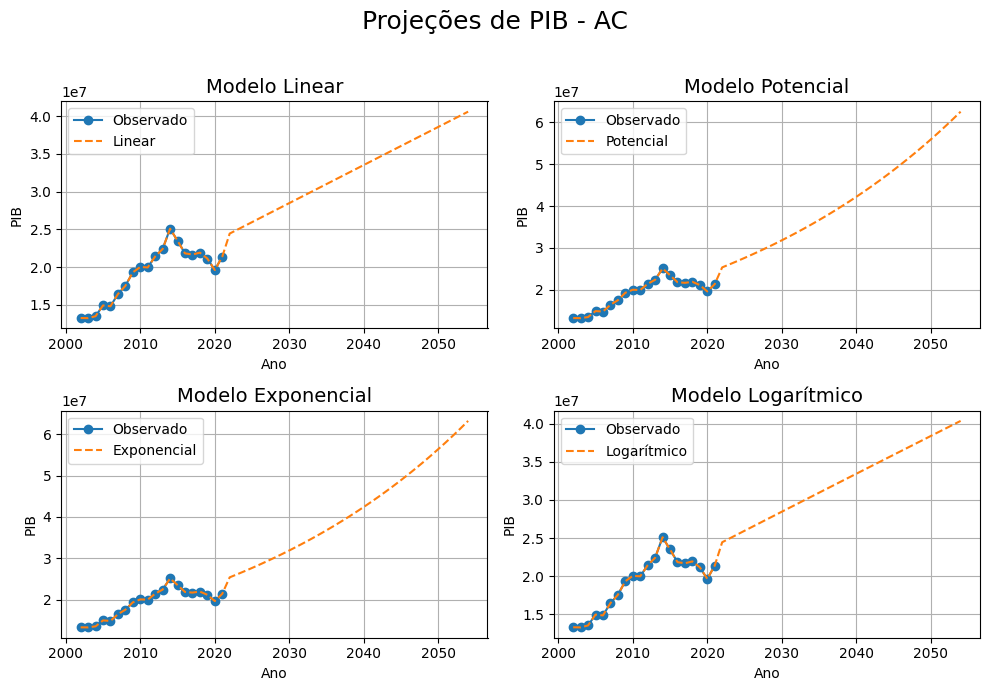

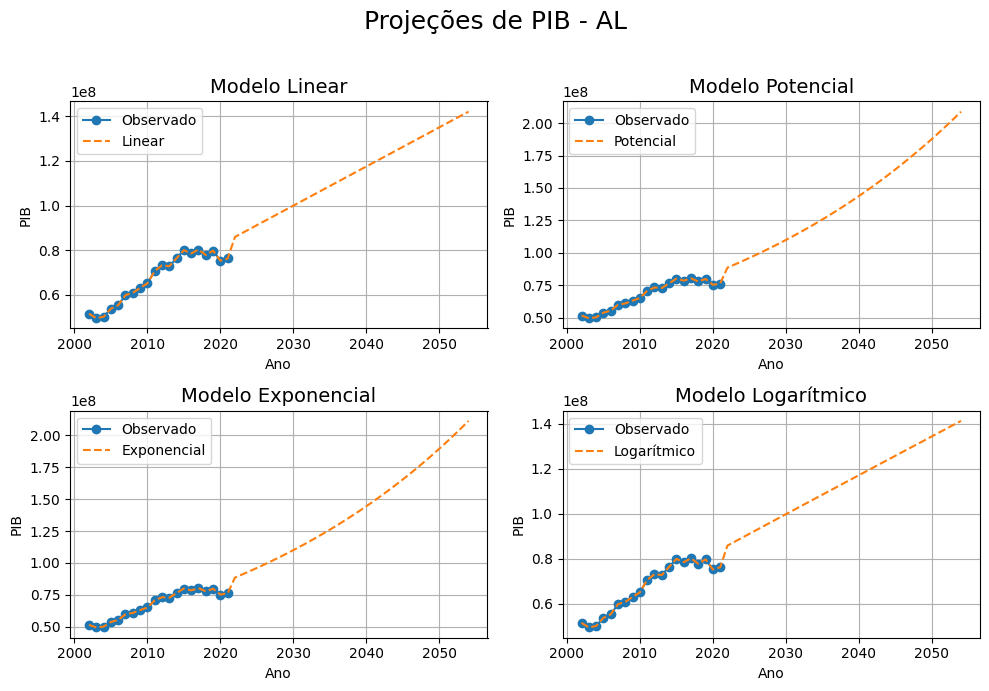

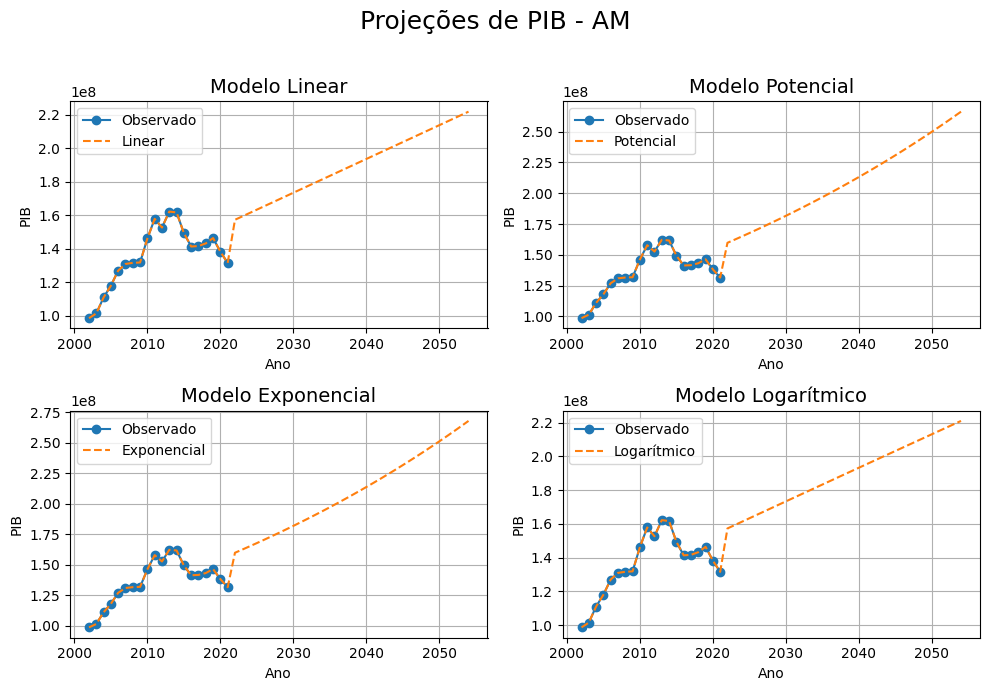

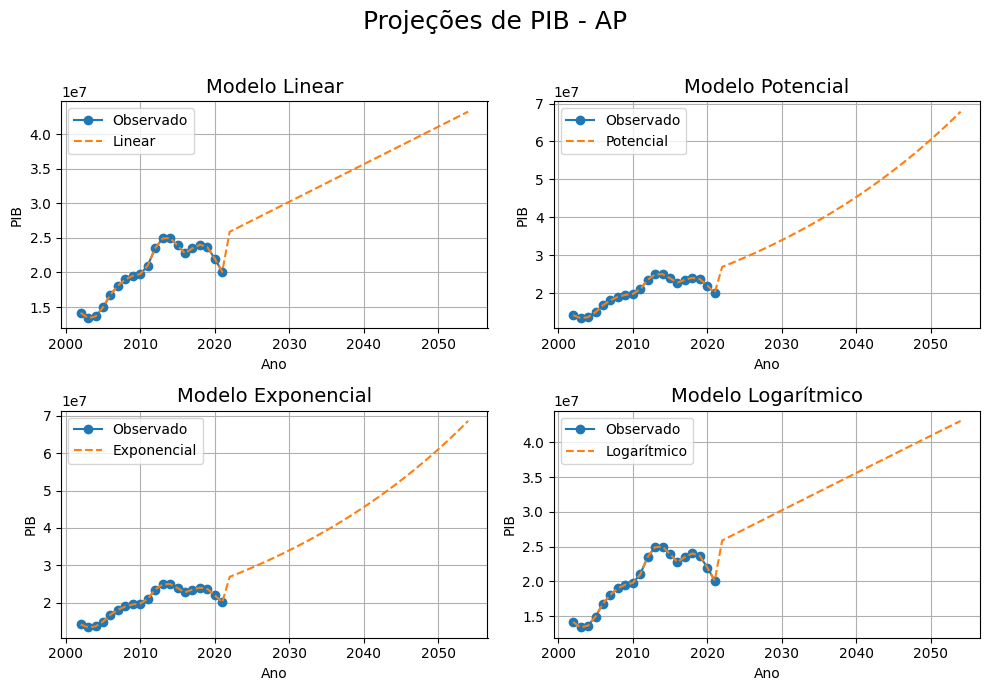

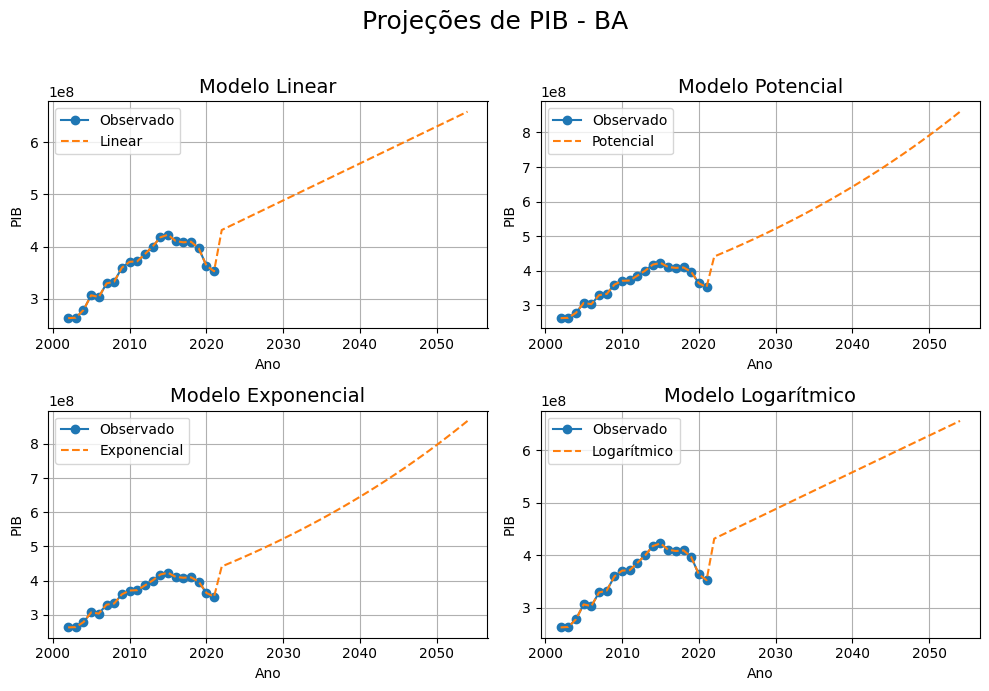

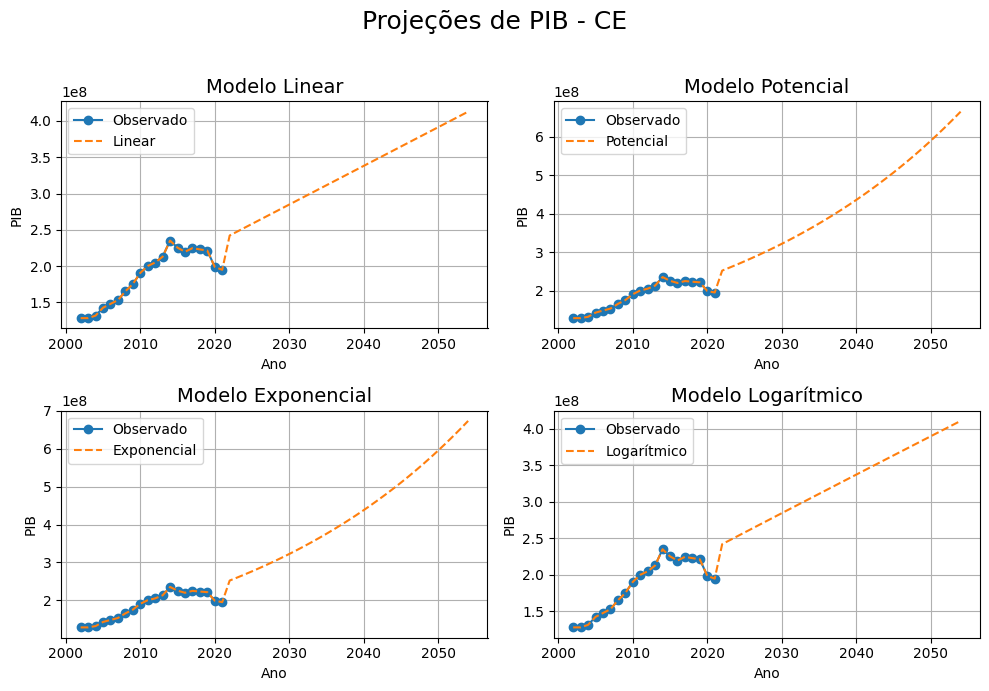

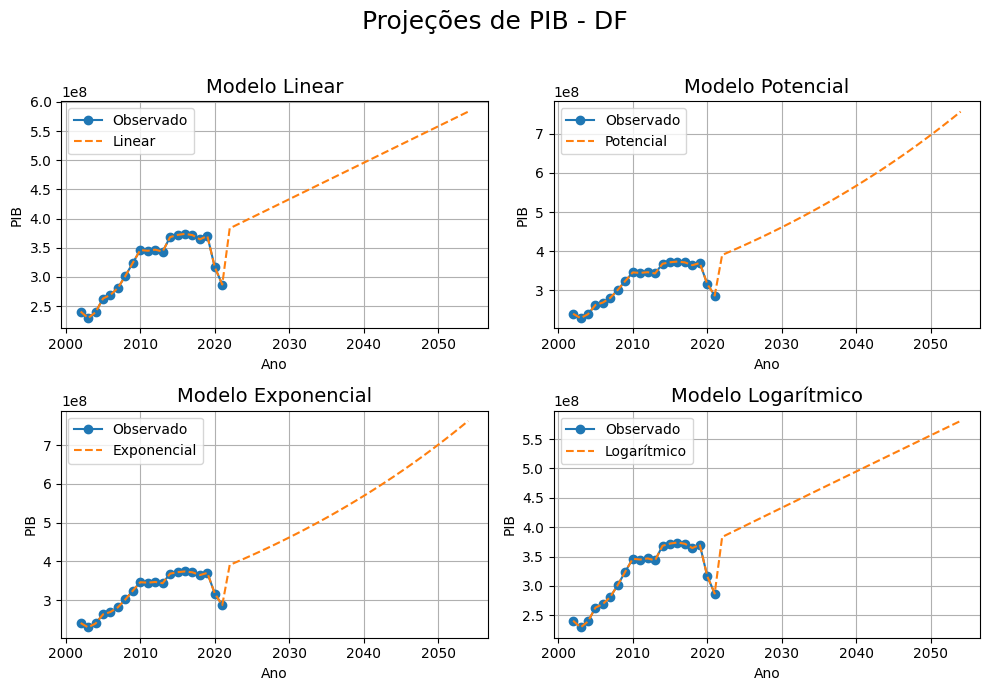

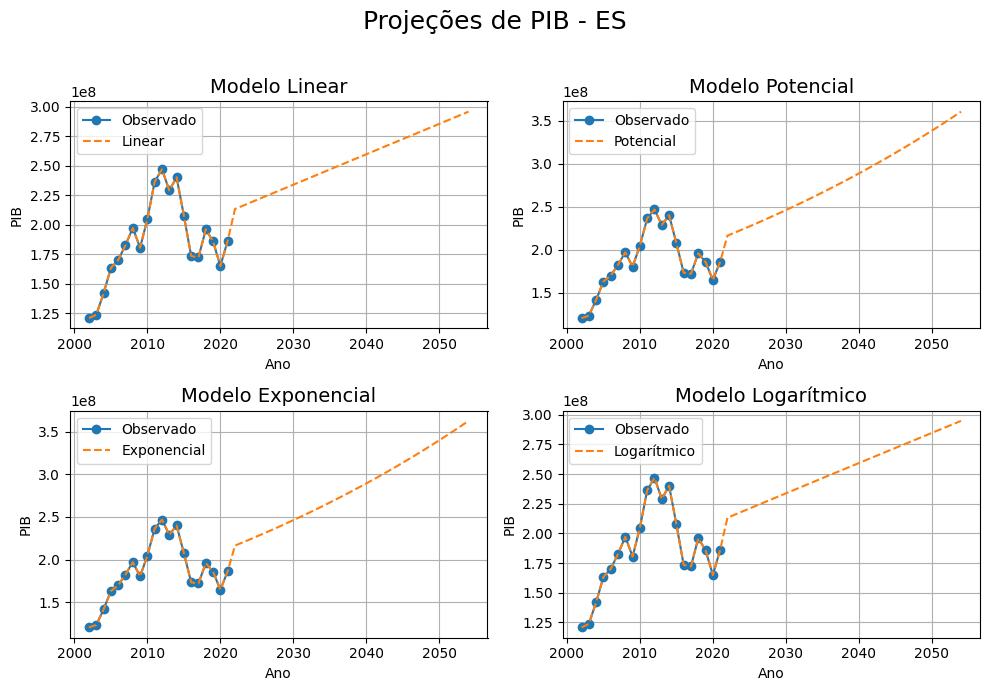

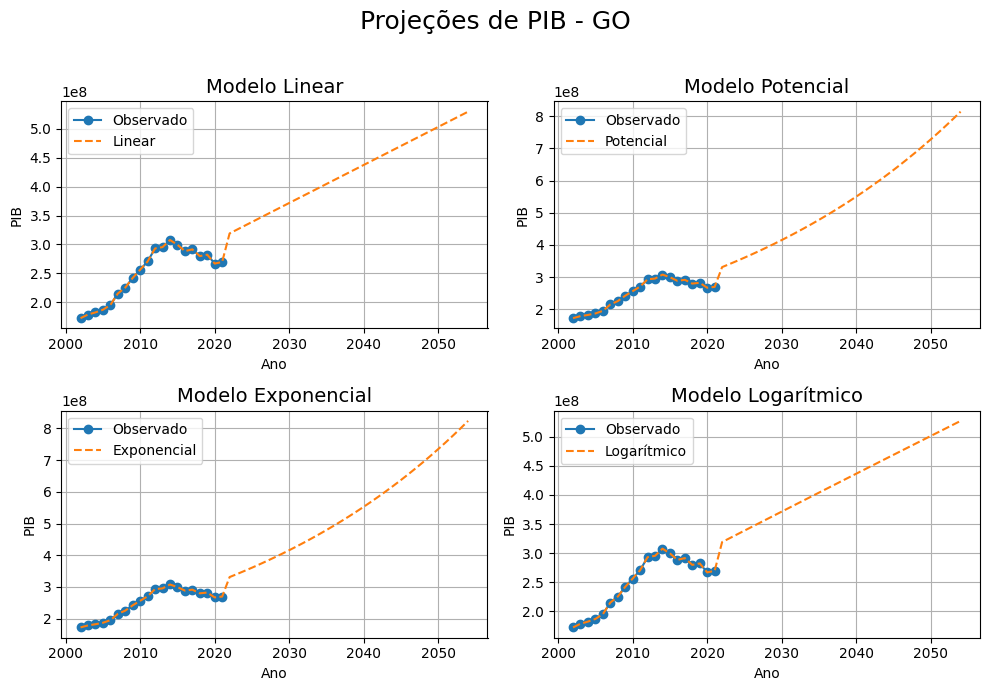

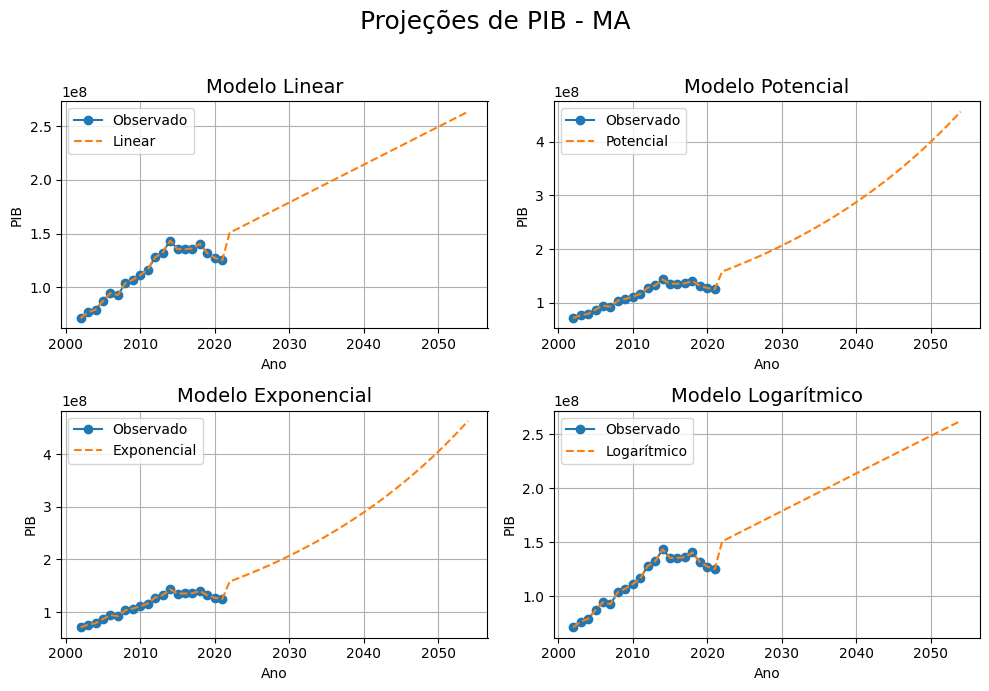

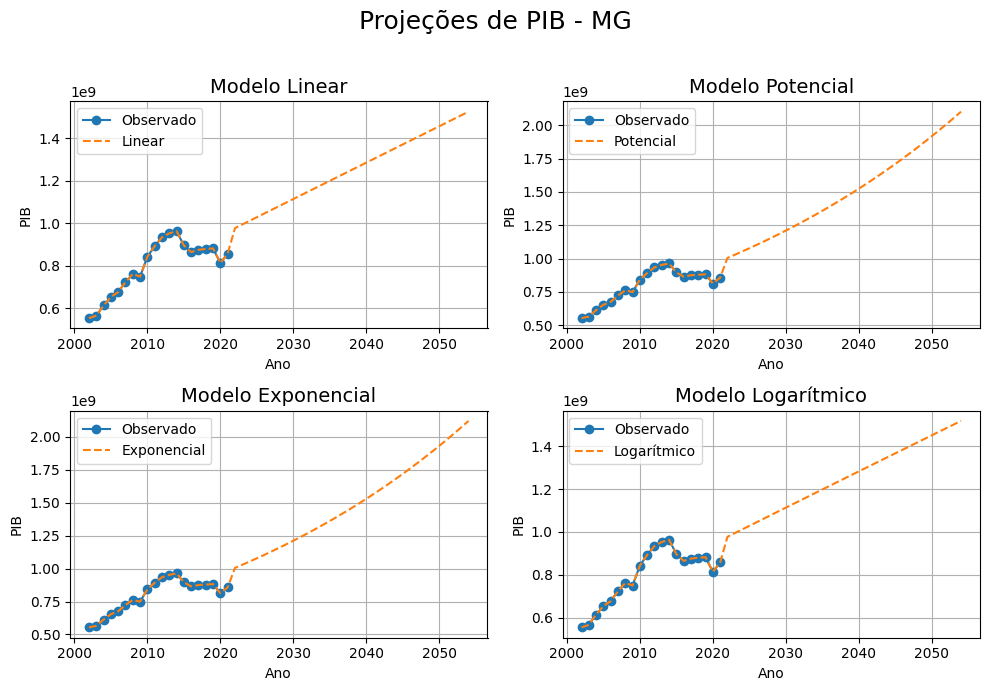

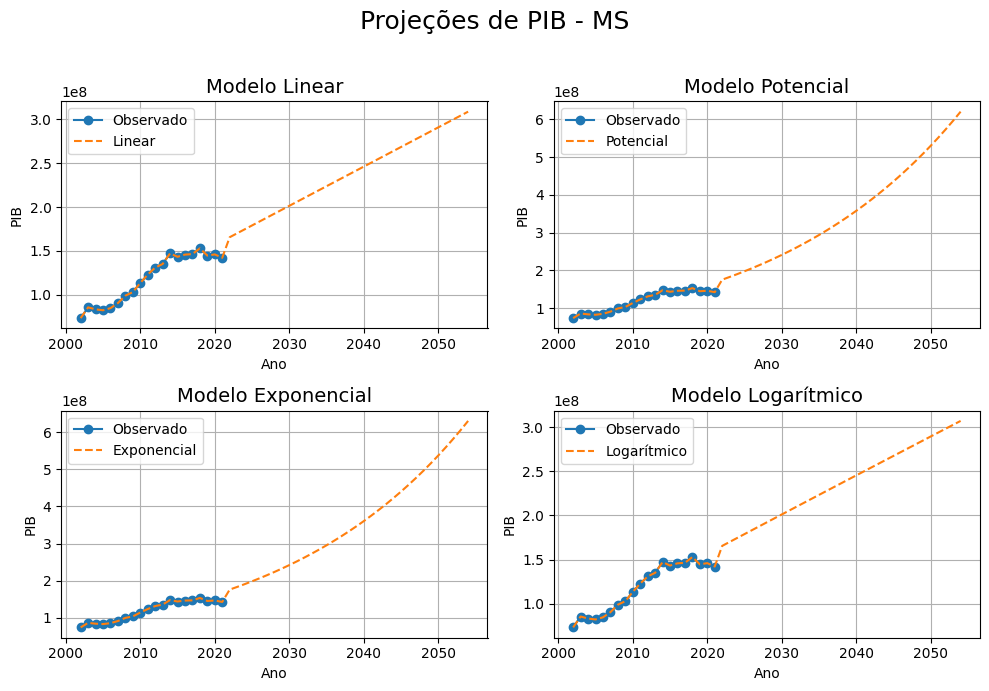

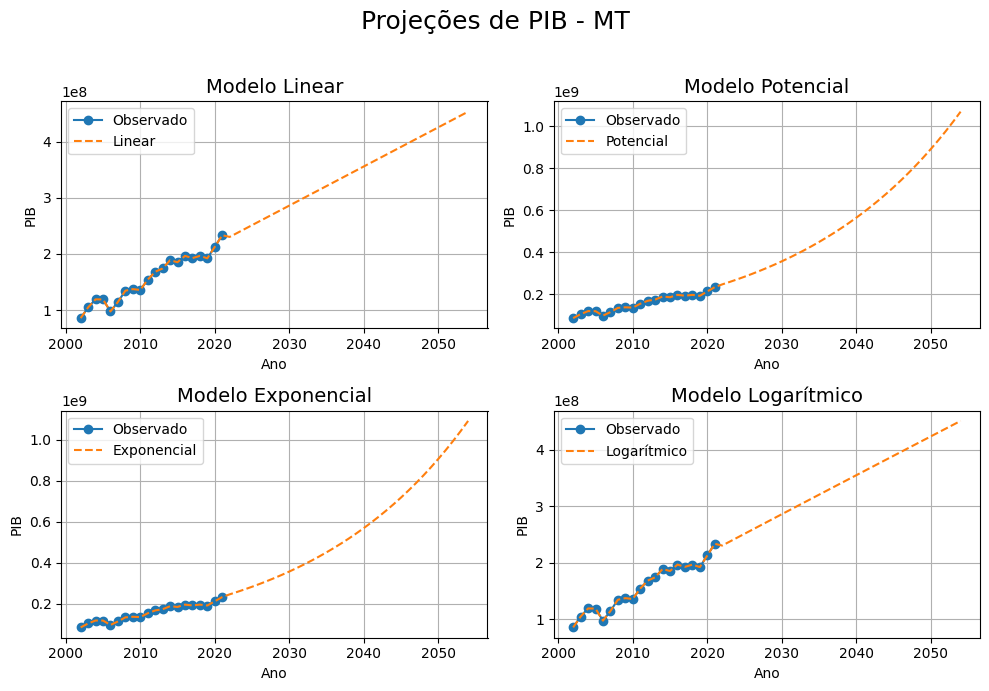

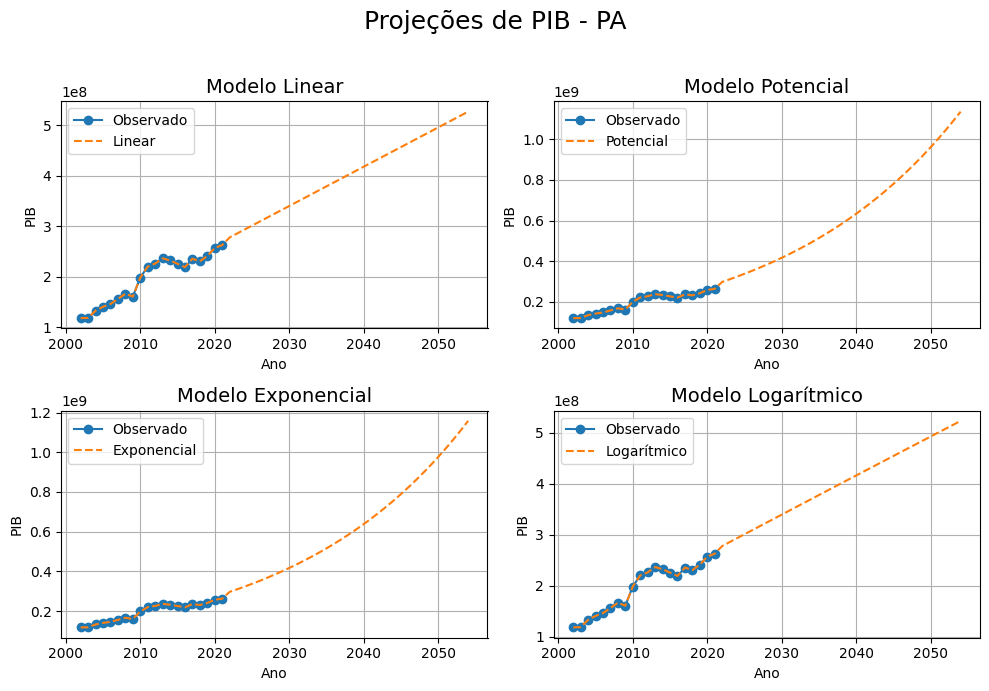

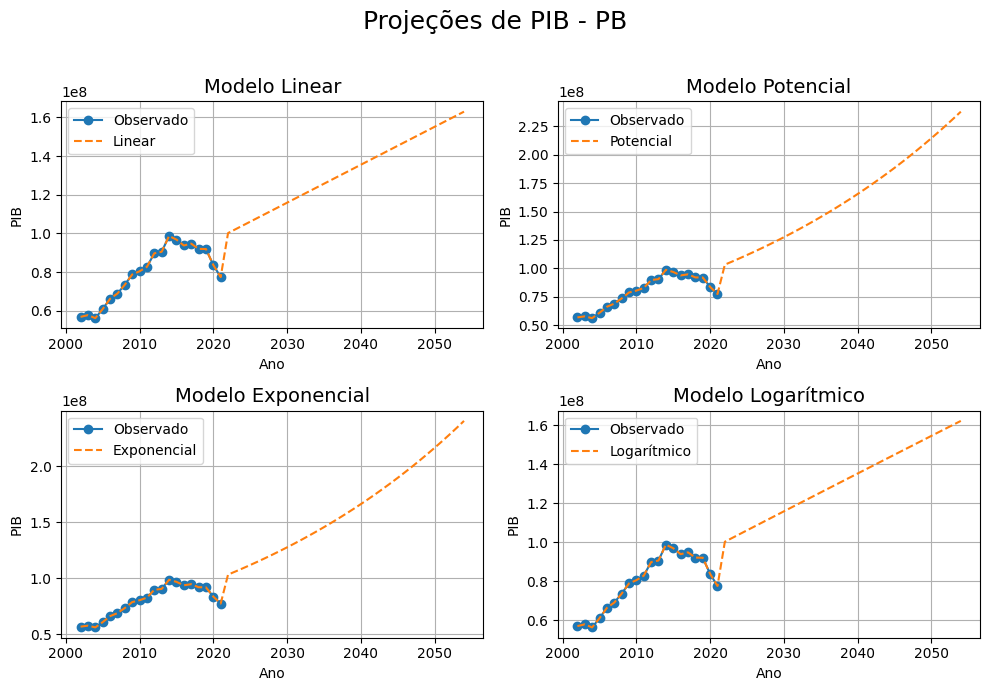

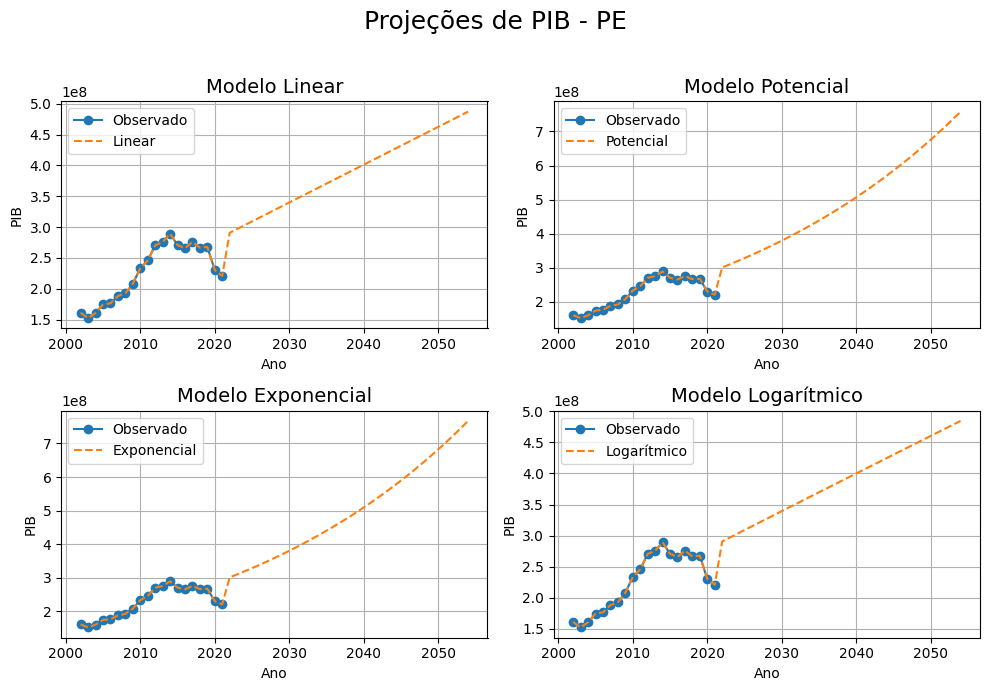

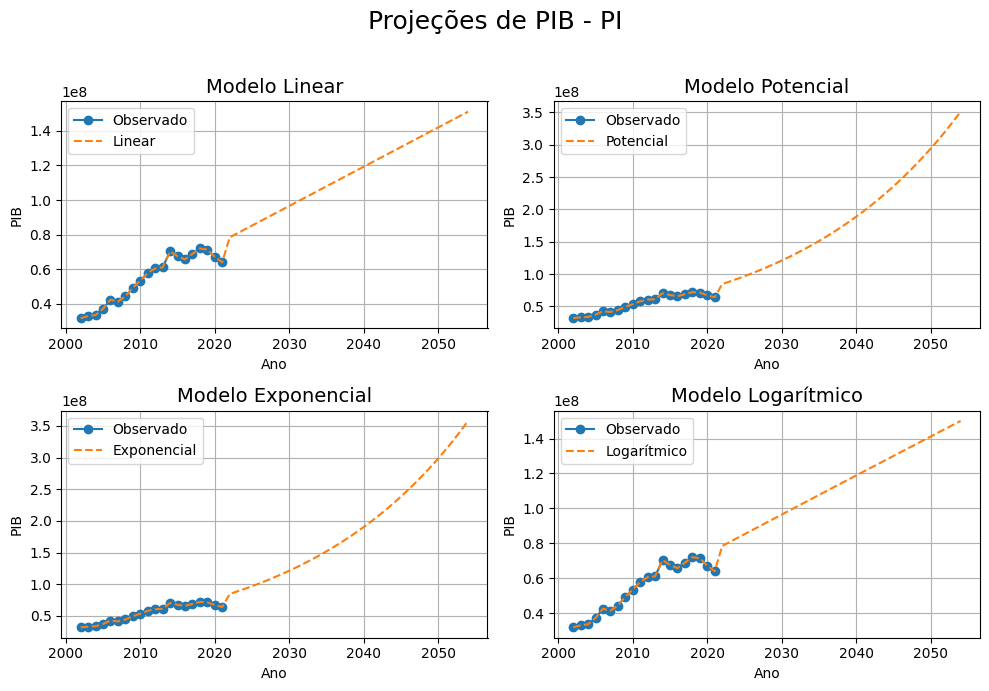

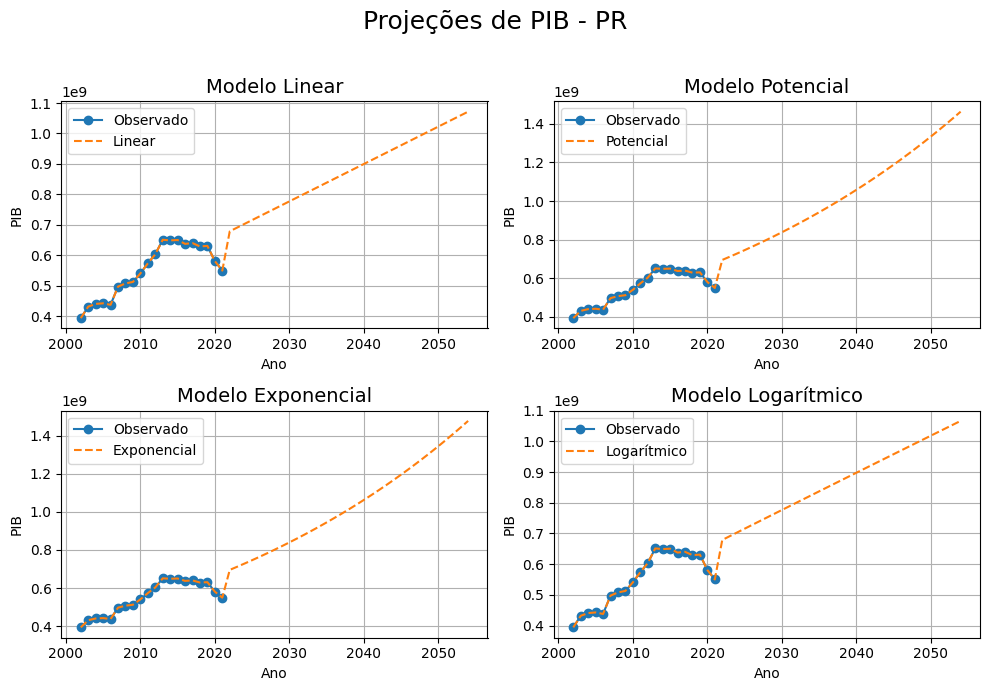

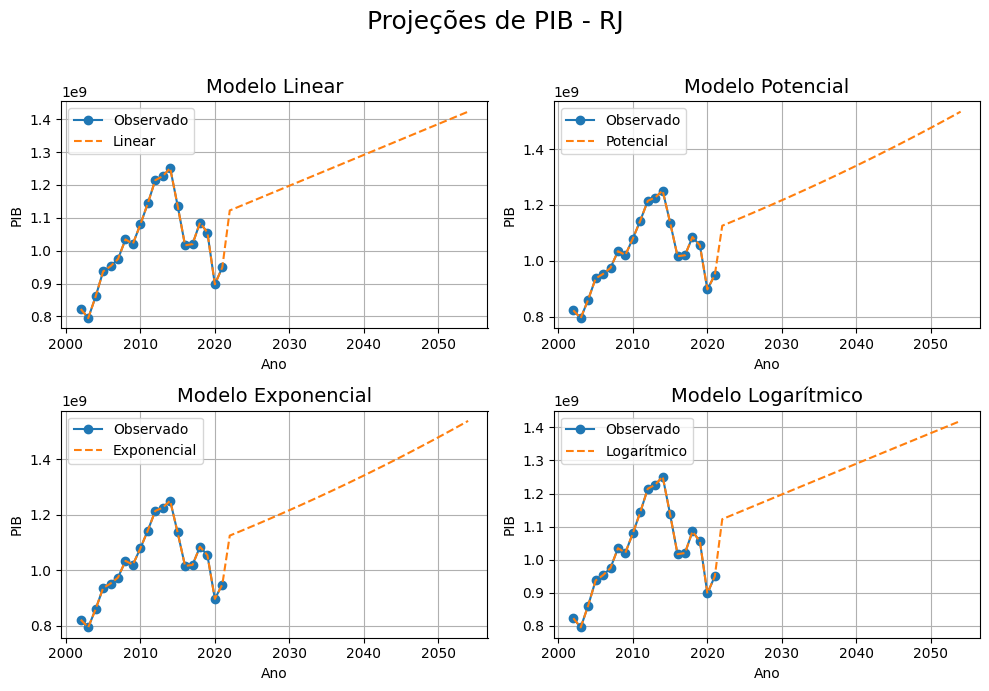

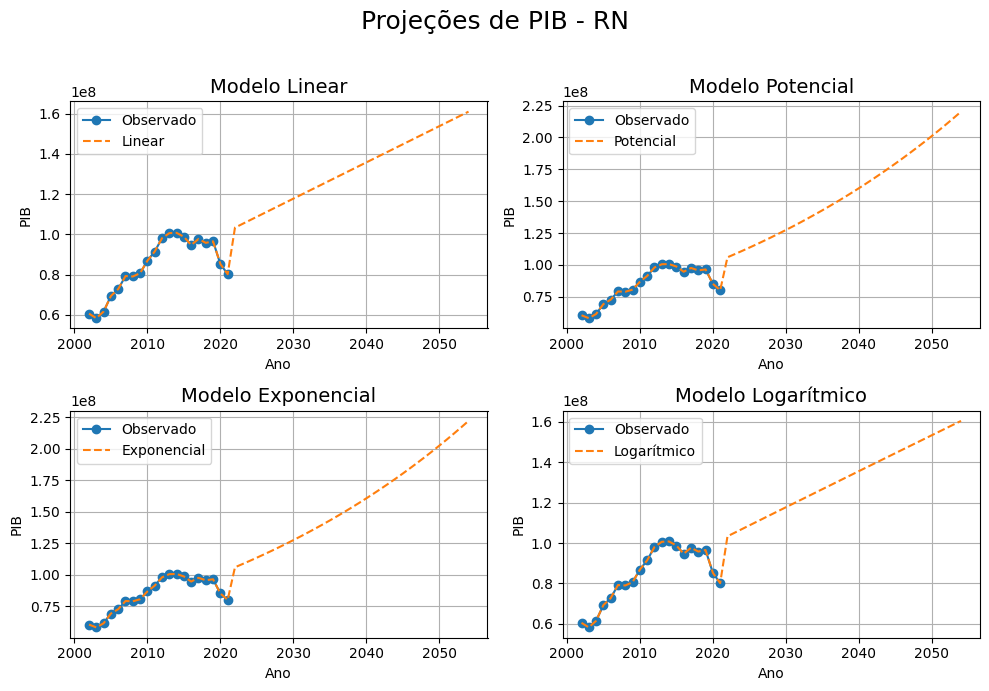

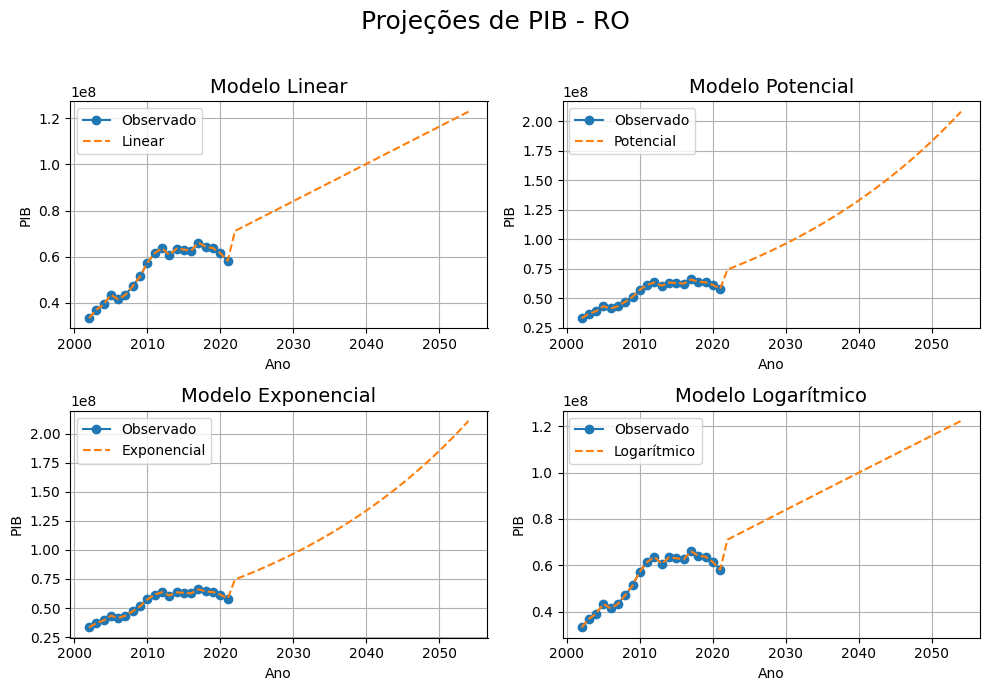

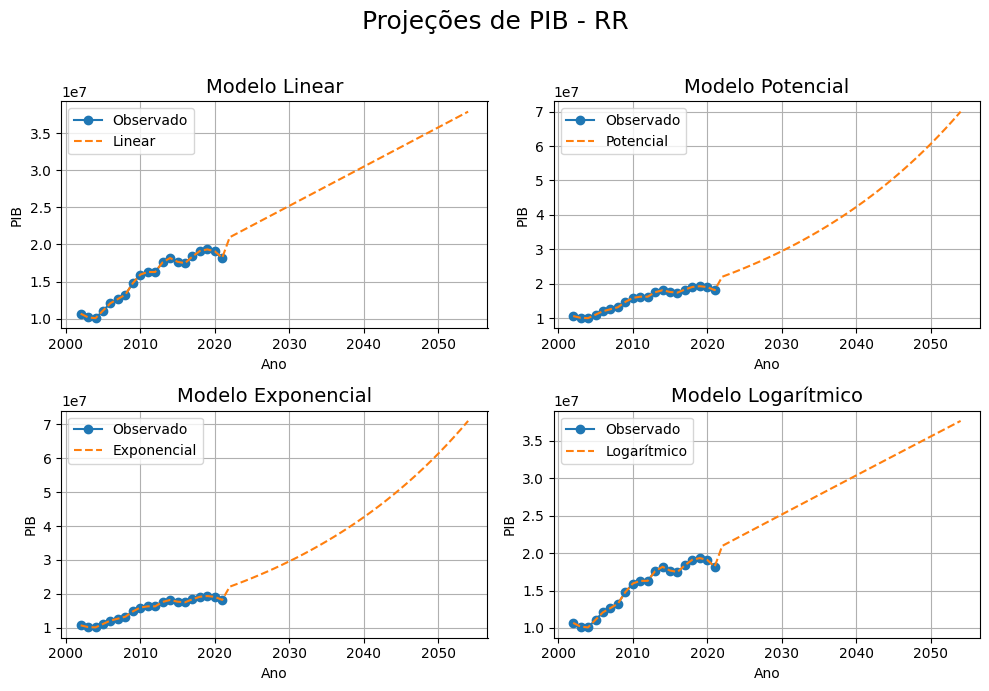

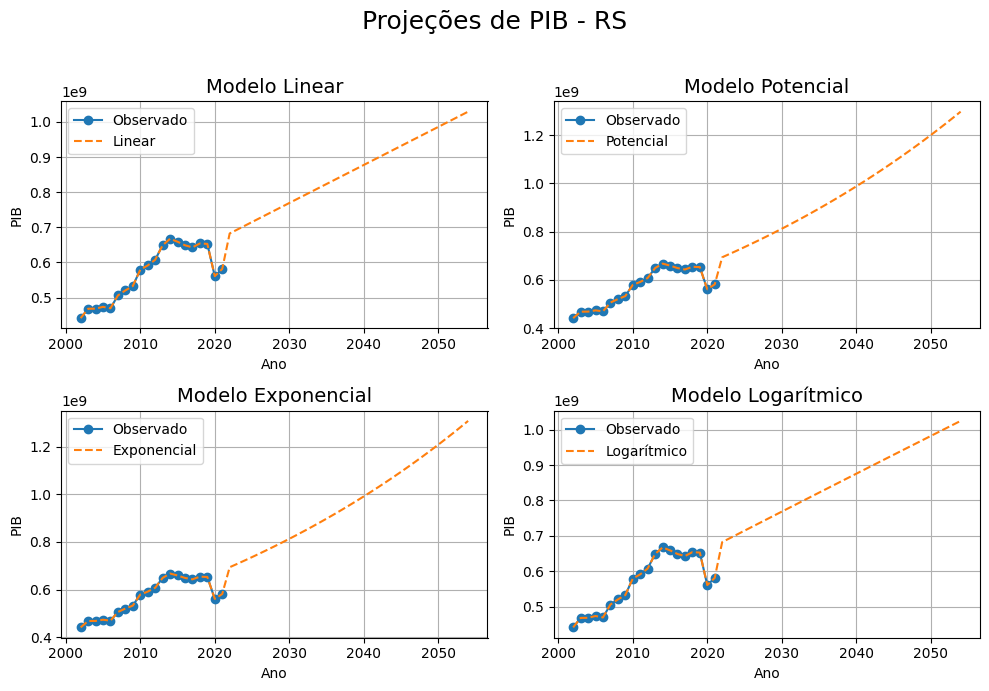

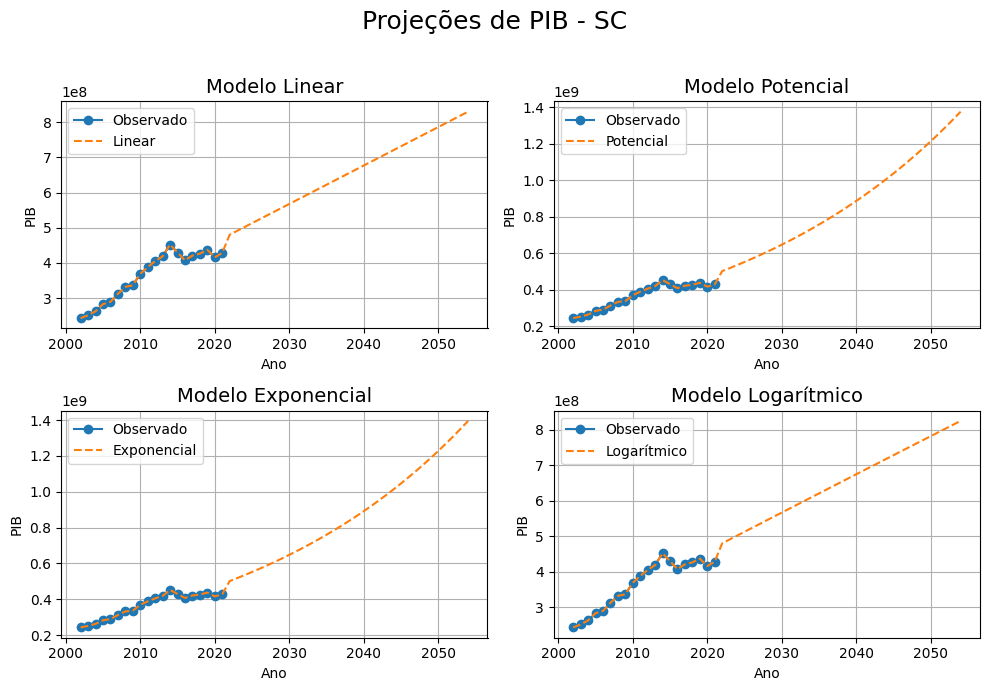

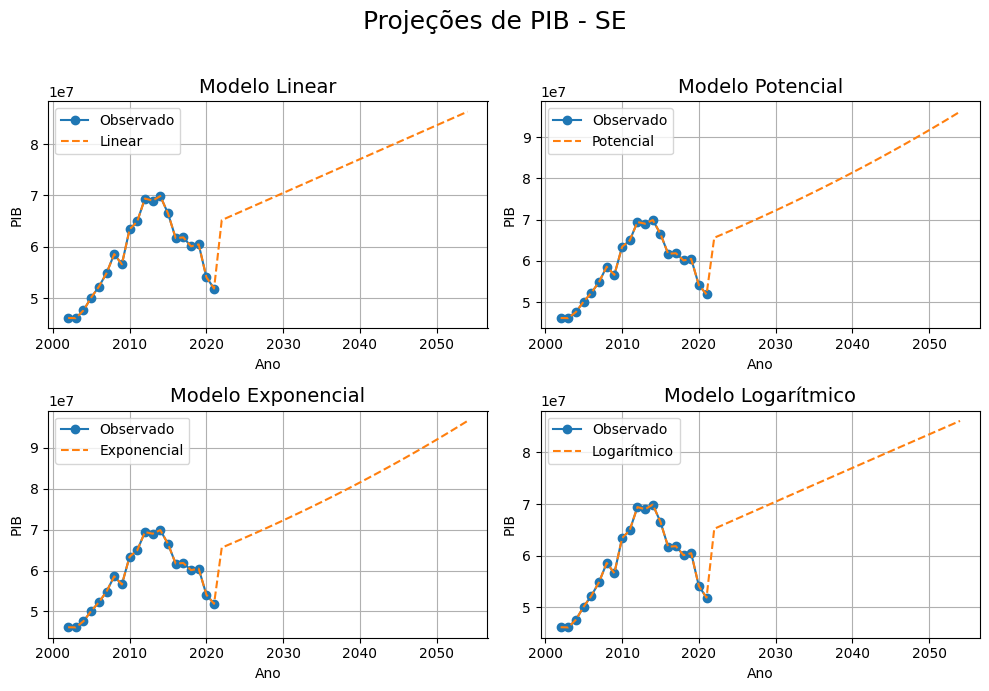

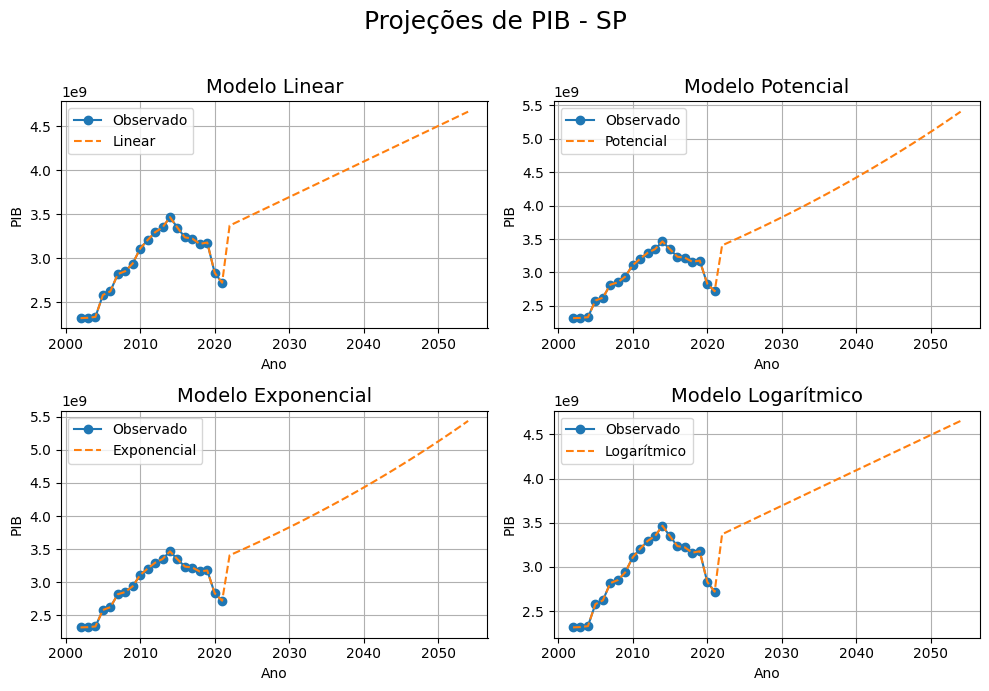

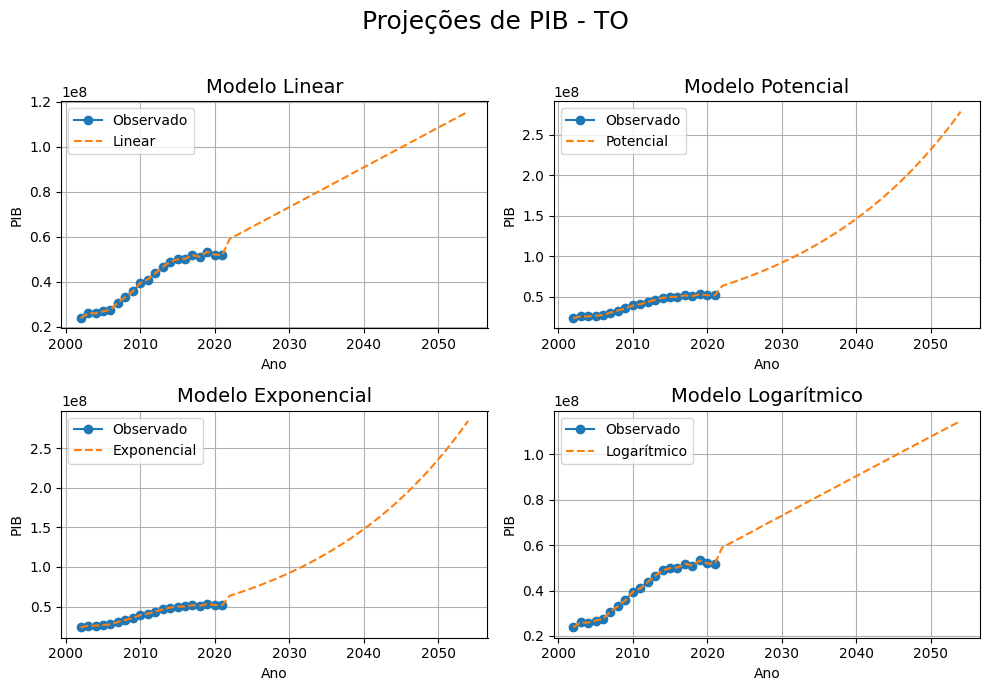

In [43]:
def plotar_pib_por_sigla_multimodelo(tabela_completa):
    siglas = tabela_completa['sigla_uf'].unique()

    for sigla in siglas:
        # Filtrar os dados para a sigla atual
        dados_sigla = tabela_completa[tabela_completa['sigla_uf'] == sigla]

        # Dividir os dados observados e projetados
        dados_observados = dados_sigla[dados_sigla['ano'] <= 2021]
        anos_projetados = dados_sigla['ano']

        # Criar a figura com 2x2 subplots
        fig, axes = plt.subplots(2, 2, figsize=(10, 7))
        fig.suptitle(f'Projeções de PIB - {sigla}', fontsize=18)

        # Gráfico para o modelo Linear
        axes[0, 0].plot(dados_observados['ano'], dados_observados['pib_uf_observado'], label='Observado', marker='o')
        axes[0, 0].plot(anos_projetados, dados_sigla['pib_uf_linear'], label='Linear', linestyle='--')
        axes[0, 0].set_title('Modelo Linear', fontsize=14)
        axes[0, 0].set_xlabel('Ano')
        axes[0, 0].set_ylabel('PIB')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # Gráfico para o modelo Potencial
        axes[0, 1].plot(dados_observados['ano'], dados_observados['pib_uf_observado'], label='Observado', marker='o')
        axes[0, 1].plot(anos_projetados, dados_sigla['pib_uf_potencial'], label='Potencial', linestyle='--')
        axes[0, 1].set_title('Modelo Potencial', fontsize=14)
        axes[0, 1].set_xlabel('Ano')
        axes[0, 1].set_ylabel('PIB')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Gráfico para o modelo Exponencial
        axes[1, 0].plot(dados_observados['ano'], dados_observados['pib_uf_observado'], label='Observado', marker='o')
        axes[1, 0].plot(anos_projetados, dados_sigla['pib_uf_exponencial'], label='Exponencial', linestyle='--')
        axes[1, 0].set_title('Modelo Exponencial', fontsize=14)
        axes[1, 0].set_xlabel('Ano')
        axes[1, 0].set_ylabel('PIB')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Gráfico para o modelo Logarítmico
        axes[1, 1].plot(dados_observados['ano'], dados_observados['pib_uf_observado'], label='Observado', marker='o')
        axes[1, 1].plot(anos_projetados, dados_sigla['pib_uf_logaritmico'], label='Logarítmico', linestyle='--')
        axes[1, 1].set_title('Modelo Logarítmico', fontsize=14)
        axes[1, 1].set_xlabel('Ano')
        axes[1, 1].set_ylabel('PIB')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        # Ajustar layout
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        # Mostrar os gráficos
        plt.show()

# Exemplo de uso
plotar_pib_por_sigla_multimodelo(pib_uf_projecao_completa)


In [44]:
def atualizar_pib_municipal(pib_municipal_transformado, pib_uf_projecao_completa):
    # Remover a coluna 'corretor_total' e usar 'pib_mun_corrigido' como 'pib_mun'
    pib_municipal_transformado = pib_municipal_transformado.drop(columns=['pib_mun', 'corretor_total'], errors='ignore')
    pib_municipal_transformado = pib_municipal_transformado.rename(columns={'pib_mun_corrigido': 'pib_mun'})

    # Criar o intervalo de anos de 2002 a 2054
    anos_completos = pd.DataFrame({'ano': range(2002, 2055)})
    municipios = pib_municipal_transformado[['cod_mun', 'municipio', 'sigla_uf']].drop_duplicates()
    todos_anos = municipios.merge(anos_completos, how='cross')
    
    # Unir os dados com os anos completos
    pib_municipal_completo = todos_anos.merge(
        pib_municipal_transformado,
        how='left',
        on=['cod_mun', 'municipio', 'sigla_uf', 'ano']
    )
    
    # Manter apenas a coluna 'pib_uf' do DataFrame 'pib_uf_projecao_completa'
    pib_uf_projecao = pib_uf_projecao_completa[['sigla_uf', 'ano', 'pib_uf_logaritmico']].rename(columns={'pib_uf_logaritmico': 'pib_uf'})

    # Adicionar a coluna 'pib_uf' com base na correspondência de 'sigla_uf' e 'ano'
    pib_municipal_completo = pib_municipal_completo.merge(
        pib_uf_projecao,
        how='left',
        on=['sigla_uf', 'ano']
    )

    # Garantir que 'ano' seja numérico inteiro
    pib_municipal_completo['ano'] = pd.to_numeric(pib_municipal_completo['ano'], errors='coerce').astype('Int64')

    # Garantir que 'pib_uf' e 'pib_mun' sejam numéricos decimais
    pib_municipal_completo['pib_uf'] = pd.to_numeric(pib_municipal_completo['pib_uf'], errors='coerce')
    pib_municipal_completo['pib_mun'] = pd.to_numeric(pib_municipal_completo['pib_mun'], errors='coerce')
    
    # Garantir que 'pib_mun' fique vazio de 2022 a 2054 inicialmente
    pib_municipal_completo.loc[pib_municipal_completo['ano'].between(2022, 2054), 'pib_mun'] = None
    
    # Preencher 'pib_mun' para os anos de 2022 a 2054
    for ano_atual in range(2022, 2055):  # Inclui 2054
        ano_anterior = ano_atual - 1
        
        # Criar DataFrame apenas com os valores do ano anterior, garantindo a correspondência por 'cod_mun'
        df_anterior = pib_municipal_completo.loc[
            pib_municipal_completo['ano'] == ano_anterior,
            ['cod_mun', 'pib_uf', 'pib_mun']
        ].rename(columns={'pib_uf': 'pib_uf_anterior', 'pib_mun': 'pib_mun_anterior'})

        # Mesclar os valores do período anterior com base em 'cod_mun'
        pib_municipal_completo = pib_municipal_completo.merge(
            df_anterior,
            how='left',
            on='cod_mun',
            suffixes=('', '_anterior')
        )

        # Calcular o valor de 'pib_mun' atual somente para registros do ano atual
        condicao_atual = pib_municipal_completo['ano'] == ano_atual
        pib_municipal_completo.loc[condicao_atual, 'pib_mun'] = (
            (pib_municipal_completo['pib_uf'] / pib_municipal_completo['pib_uf_anterior'] * 
             pib_municipal_completo['pib_mun_anterior']).round()
        )
        
        # Remover colunas temporárias
        pib_municipal_completo.drop(columns=['pib_uf_anterior', 'pib_mun_anterior'], inplace=True)
    
    return pib_municipal_completo

# Exemplo de uso
pib_municipal_final = atualizar_pib_municipal(pib_municipal_transformado, pib_uf_projecao_completa)

# Unificação em planilha única

In [45]:
pop_municipal_final.columns

Index(['cod_mun', 'municipio', 'sigla_uf', 'ano', 'pop_mun', 'pop_uf'], dtype='object')

In [46]:
pib_municipal_final.columns

Index(['cod_mun', 'municipio', 'sigla_uf', 'ano', 'pib_mun', 'pib_uf'], dtype='object')

In [47]:
def combinar_pop_pib(pop_municipal_final, pib_municipal_final):
    # Realizar a junção com base nas colunas 'cod_mun', 'municipio', 'sigla_uf', 'ano'
    combinado = pop_municipal_final.merge(
        pib_municipal_final,
        on=['cod_mun', 'municipio', 'sigla_uf', 'ano'],
        how='inner'
    )
    
    # Garantir que as colunas necessárias sejam numéricas
    combinado['pop_mun'] = pd.to_numeric(combinado['pop_mun'], errors='coerce')
    combinado['pop_uf'] = pd.to_numeric(combinado['pop_uf'], errors='coerce')
    combinado['pib_mun'] = pd.to_numeric(combinado['pib_mun'], errors='coerce')
    combinado['pib_uf'] = pd.to_numeric(combinado['pib_uf'], errors='coerce')

    # Calcular o PIB per capita municipal
    combinado['pib_per_capita_mun'] = (combinado['pib_mun'] / combinado['pop_mun']).round(2)
    
    # Calcular o PIB per capita estadual
    combinado['pib_per_capita_uf'] = (combinado['pib_uf'] / combinado['pop_uf']).round(2)

    return combinado

# Exemplo de uso
projecao_pop_pib_final = combinar_pop_pib(pop_municipal_final, pib_municipal_final)

In [62]:
def calcular_crescimento_ponderado(projecao_pop_pib_final):
    # Filtrar para as siglas de interesse
    siglas_de_interesse = ['DF', 'MG', 'GO', 'BA', 'SE', 'AL', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA', 'TO', 'PA']
    projecao_pop_pib_final = projecao_pop_pib_final[projecao_pop_pib_final['sigla_uf'].isin(siglas_de_interesse)]

    # Ordenar os dados para garantir consistência
    projecao_pop_pib_final = projecao_pop_pib_final.sort_values(by=['cod_mun', 'ano']).reset_index(drop=True)

    # Calcular crescimento anual para 'pib_mun' e 'pop_mun' com fill_method=None
    projecao_pop_pib_final['crescimento_pib'] = projecao_pop_pib_final.groupby('cod_mun')['pib_mun'].pct_change(fill_method=None)
    projecao_pop_pib_final['crescimento_pop'] = projecao_pop_pib_final.groupby('cod_mun')['pop_mun'].pct_change(fill_method=None)
    projecao_pop_pib_final['crescimento_pib_per_capita'] = projecao_pop_pib_final.groupby('cod_mun')['pib_per_capita_mun'].pct_change(fill_method=None)

    # Calcular a média dos dois crescimentos (ponderado)
    projecao_pop_pib_final['crescimento_ponderado'] = (
        projecao_pop_pib_final[['crescimento_pib', 'crescimento_pop']].mean(axis=1)
    )

    # Remover as linhas onde crescimento_ponderado é NaN
    projecao_pop_pib_final = projecao_pop_pib_final[
        ~projecao_pop_pib_final[['crescimento_ponderado', 'crescimento_pib_per_capita']].isin([np.nan, np.inf, -np.inf]).any(axis=1)
    ].reset_index(drop=True)

    # Remover colunas temporárias
    projecao_pop_pib_final.drop(columns=['pop_uf', 'pib_uf', 'pib_per_capita_uf', 'crescimento_pib', 'crescimento_pop', 'crescimento_pib_per_capita'], inplace=True)

    # Remover as linhas de anos observados
    projecao_pop_pib_final = projecao_pop_pib_final[
        (projecao_pop_pib_final['ano'] >= 2022)
    ].reset_index(drop=True)

    return projecao_pop_pib_final

# Exemplo de uso
projecao_crescimento = calcular_crescimento_ponderado(projecao_pop_pib_final)

In [49]:
projecao_pop_pib_final.to_csv('data/csv/projecao_pop_pib.csv', index = False)

In [64]:
projecao_crescimento.to_excel('data/excel/xlsx/projecao_crescimento.xlsx', index = False)